In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
import zipfile
import scipy.linalg
import scipy.sparse.linalg
import tqdm

In [2]:
#define relevant constants

#Z boson mass
mZ = 91.188

#Z boson width
gammaZ = 2.4414

#QED running coupling
alpha = 1/(132.507)

#Fermi constant
GF = 1.16639*10**(-5)

#weinberg angle
thetaW = 0.222246

kappa = (np.sqrt(2)*GF*mZ**2)/(4*np.pi*alpha)

In [3]:
#relevant constants to electrons and muons

#electron charge 
Q_e = -1

#electron vector coupling
V_e = -1/2+2*thetaW

#electron axial vector coupling
A_e = -1/2

#muon vector coupling
V_mu = -1/2+2*thetaW

#muon axial vector coupling
A_mu = -1/2

In [4]:
#function for calculating chi_1
def chi_1(s):
    return (kappa*s*(s-mZ**2))/((s-mZ**2)**2+gammaZ**2*mZ**2)

In [5]:
#function for calculating chi_2
def chi_2(s):
    return (kappa**2*s**2)/((s-mZ**2)**2+gammaZ**2*mZ**2)

In [6]:
#function for calculating A_0
def A_0(s):
    term_1 = Q_e**2-2*Q_e*V_mu*V_e*chi_1(s)
    term_2 = (A_mu**2+V_mu**2)*(A_e**2+V_e**2)*chi_2(s)
    return term_1 + term_2

In [7]:
#function for calculating A_1
def A_1(s):
    term_1 = -4*Q_e*A_mu*A_e*chi_1(s)
    term_2 = 8*A_mu*V_mu*A_e*V_e*chi_2(s)
    return term_1 + term_2

In [8]:
#calculate the differential cross section for an event
def cross_section(s,cos_theta):
    return (alpha**2/(4*s))*(A_0(s)*(1+cos_theta**2)+A_1(s)*cos_theta)

In [9]:
#constants for mcmc
E_min = 10
E_max = 200
N_steps = 10_000_000
burn_in = 100_000
thinning = 10

In [10]:
# acceptance-rejection MCMC method to generate drell-yan events
def mcmc():
    events = []
    max_cs = 0

    #find max cross section for rejection 
    #(doing a discrete search - can do better in paper)
    for i in np.linspace(E_min**2, E_max**2, 1000):
        max_cs = max(max_cs, cross_section(i, 0))
    
    for t in tqdm.tqdm(range(N_steps)):
        
        #sample randomly
        E_cm = np.random.uniform(E_min, E_max)
        cos_theta = np.random.uniform(-1,1)

        #calculate s
        s = E_cm**2

        #calculate diff cross section
        cs = cross_section(s, cos_theta)

        #random number 
        u = np.random.uniform(0,1)
        
        #acceptance-rejection
        if u < cs / (max_cs):
            #accept this event after burn in
            if t >= burn_in:
                events.append((E_cm, cos_theta))

    #thinning
    events = events[::thinning]
    
    return np.array(events)

100%|██████████| 10000000/10000000 [02:46<00:00, 60100.75it/s]


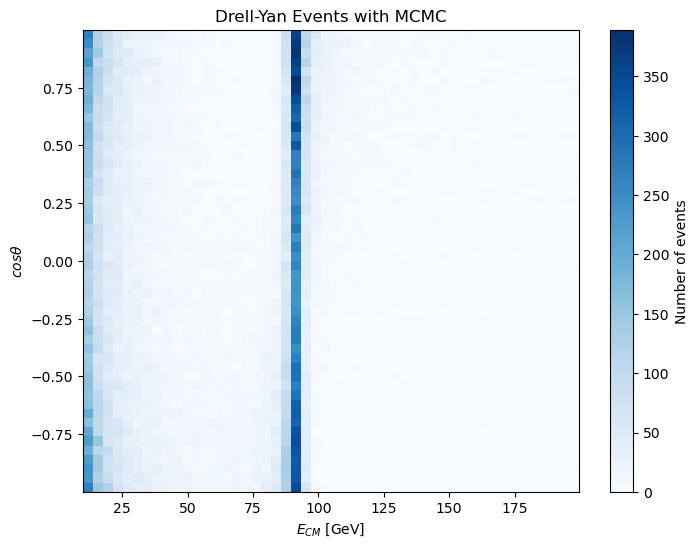

In [11]:
events = mcmc()
        
plt.figure(figsize=(8,6))
plt.hist2d(events[:, 0], events[:, 1], bins=50, cmap='Blues')
plt.colorbar(label="Number of events")
plt.xlabel("$E_{CM}$ [GeV]")
plt.ylabel("$cos\\theta$")
plt.title("Drell-Yan Events with MCMC")
plt.show()

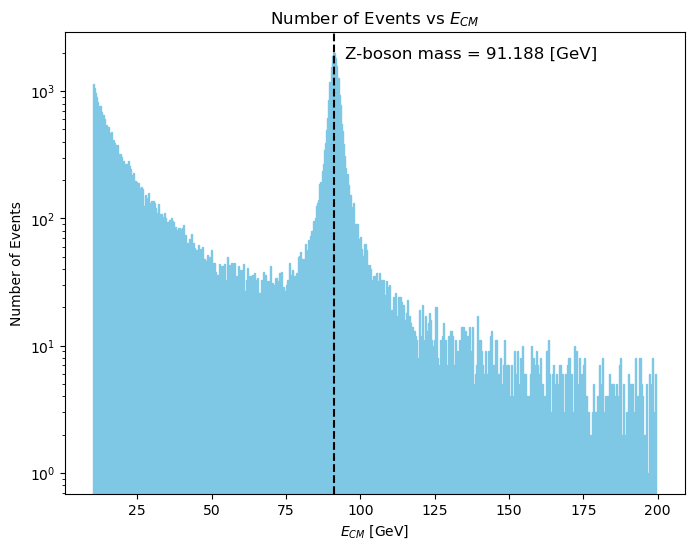

In [12]:
energy_values = events[:, 0]

#plot
plt.figure(figsize=(8, 6))
plt.hist(energy_values, bins=500, color='#7EC8E6', edgecolor='#7EC8E6')
plt.xlabel("$E_{CM}$ [GeV]")
plt.ylabel("Number of Events")
plt.title("Number of Events vs $E_{CM}$")
plt.axvline(x=91.188, color='black', linestyle='--')
plt.text(95, 1700, "Z-boson mass = 91.188 [GeV]", color='black', fontsize=12, verticalalignment='bottom')
plt.yscale('log')

plt.show()

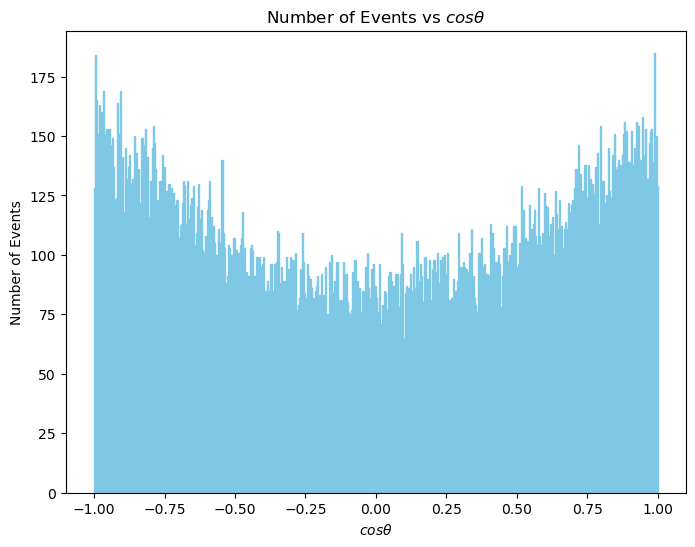

In [13]:
cos_theta_values = events[:, 1]

#plot
plt.figure(figsize=(8, 6))
plt.hist(cos_theta_values, bins=500, color='#7EC8E6', edgecolor='#7EC8E6')
plt.xlabel("$cos\\theta$")
plt.ylabel("Number of Events")
plt.title("Number of Events vs $cos\\theta$")

plt.show()